In [24]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

#acquire
import acquire
from env import host, username, password
from pydataset import data
from sklearn.impute import SimpleImputer

# Acquire & Prep Data

## Acquire data - zillow_data()

In [7]:
df = acquire.zillow_data()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77580 entries, 0 to 77579
Data columns (total 69 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   typeconstructiontypeid        223 non-null    float64
 1   storytypeid                   50 non-null     float64
 2   propertylandusetypeid         77580 non-null  float64
 3   heatingorsystemtypeid         49572 non-null  float64
 4   buildingclasstypeid           15 non-null     float64
 5   architecturalstyletypeid      207 non-null    float64
 6   airconditioningtypeid         25007 non-null  float64
 7   parcelid                      77580 non-null  int64  
 8   id                            77580 non-null  int64  
 9   logerror                      77580 non-null  float64
 10  transactiondate               77580 non-null  object 
 11  id                            77580 non-null  int64  
 12  basementsqft                  50 non-null     float64
 13  b

## Prep Zillow Data - prepare_zillow()

In [9]:
df.propertylandusedesc.value_counts()

Single Family Residential                     52442
Condominium                                   19342
Duplex (2 Units, Any Combination)              2021
Planned Unit Development                       1947
Quadruplex (4 Units, Any Combination)           729
Triplex (3 Units, Any Combination)              539
Cluster Home                                    335
Mobile Home                                      74
Manufactured, Modular, Prefabricated Homes       59
Residential General                              42
Cooperative                                      29
Commercial/Office/Residential Mixed Used         15
Townhouse                                         6
Name: propertylandusedesc, dtype: int64

***
Single unit properties - Single Family Residential, Mobile Home, Manufactured, Modular, Prefabricated Homes, Townhouse
* Townhouse only has 6 so drop
***

In [10]:
# Restrict propertylandusedesc to those of single unit
df = df[(df.propertylandusedesc == 'Single Family Residential') | 
        (df.propertylandusedesc == 'Mobile Home') |
        (df.propertylandusedesc == 'Manufactured, Modular, Prefabricated Homes')]

In [14]:
# null values
df.isnull().sum()

propertylandusetypeid               0
heatingorsystemtypeid           18639
parcelid                            0
id                                  0
logerror                            0
transactiondate                     0
id                                  0
bathroomcnt                         0
bedroomcnt                          0
buildingqualitytypeid           18783
calculatedbathnbr                 175
calculatedfinishedsquarefeet      102
finishedsquarefeet12              309
fips                                0
fullbathcnt                       175
latitude                            0
longitude                           0
lotsizesquarefeet                 375
propertycountylandusecode           0
propertyzoningdesc              18672
rawcensustractandblock              0
regionidcity                     1037
regionidcounty                      0
regionidzip                        27
roomcnt                             0
unitcnt                         18674
yearbuilt   

In [11]:
# dropping cols/rows where more than half of the values are null
df = acquire.handle_missing_values(df, col_perc = .5, row_perc = .5)

In [16]:
# dropping the columns with 17K missing values too much to fill/impute/drop rows
df = df.drop(columns=['heatingorsystemtypeid', 'buildingqualitytypeid', 'propertyzoningdesc', 'unitcnt', 'heatingorsystemdesc'])

In [20]:
# organize features with missing data by discrete & continuous in order to impute missing data
discrete_col = ['calculatedbathnbr', 'fullbathcnt', 'regionidcity', 'regionidzip', 'yearbuilt', 'censustractandblock']
cont_col = ['calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount']

In [25]:
# imputing descreet columns with most frequent value
df = acquire.impute(df, 'most_frequent', discrete_col)
    
# imputing continuous columns with mean value
df = acquire.impute(df, 'mean', cont_col)

In [26]:
# single outlier in transactiondate
df.transactiondate.sort_values(ascending=False)

77579    2018-05-25
77578    2017-09-25
77577    2017-09-21
77576    2017-09-21
77575    2017-09-20
            ...    
7        2017-01-01
6        2017-01-01
3        2017-01-01
2        2017-01-01
0        2017-01-01
Name: transactiondate, Length: 52575, dtype: object

In [27]:
df.transactiondate.describe()

count          52575
unique           258
top       2017-06-30
freq             814
Name: transactiondate, dtype: object

In [28]:
# address date outlier by replacing with mode
df['transactiondate'] = df.transactiondate.replace('2018-05-25', '2017-06-30')

In [30]:
# Convert transactiondate to datetime
df['transactiondate'] = pd.to_datetime(df.transactiondate)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52575 entries, 0 to 77579
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   propertylandusetypeid         52575 non-null  float64       
 1   parcelid                      52575 non-null  int64         
 2   id                            52575 non-null  int64         
 3   logerror                      52575 non-null  float64       
 4   transactiondate               52575 non-null  datetime64[ns]
 5   id                            52575 non-null  int64         
 6   bathroomcnt                   52575 non-null  float64       
 7   bedroomcnt                    52575 non-null  float64       
 8   calculatedbathnbr             52575 non-null  float64       
 9   calculatedfinishedsquarefeet  52575 non-null  float64       
 10  finishedsquarefeet12          52575 non-null  float64       
 11  fips                        

In [32]:
# drop assessment year as it is one single year
df = df.drop(columns=(['assessmentyear']))

In [ ]:
# organize features with missing data by discrete & continuous in order to impute missing data
discrete_col = ['calculatedbathnbr', 'fullbathcnt', 'regionidcity', 'regionidzip', 'yearbuilt', 'censustractandblock']
cont_col = ['calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount']

In [16]:
X_train, X_validate, X_test = acquire.prepare_zillow(df)

train -> (27124, 30)
validate -> (11625, 30)
test -> (9688, 30)


### Control check to make sure we've addressed nulls

In [5]:
X_train.shape, X_validate.shape, X_test.shape

((27124, 30), (11625, 30), (9688, 30))

***
Note: I acquired and prepped the data above but after reviewing my data and trying to game plan, I decide to pare down collinearity by eliminating redundant information
***

### Explore collinearity amongst independent variables

In [36]:
# Separate variables by associations, adding in target
sqft = ['calculatedfinishedsquarefeet', 'finishedsquarefeet12']
bath = ['bathroomcnt', 'fullbathcnt', 'bedroomcnt', 'calculatedbathnbr']
value = ['structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount']
loc = ['latitude', 'longitude', 'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidzip', 'censustractandblock']

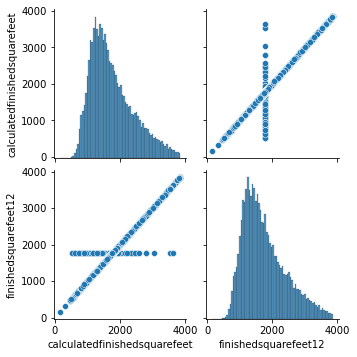

In [15]:
sns.pairplot(data = df2[sqft])

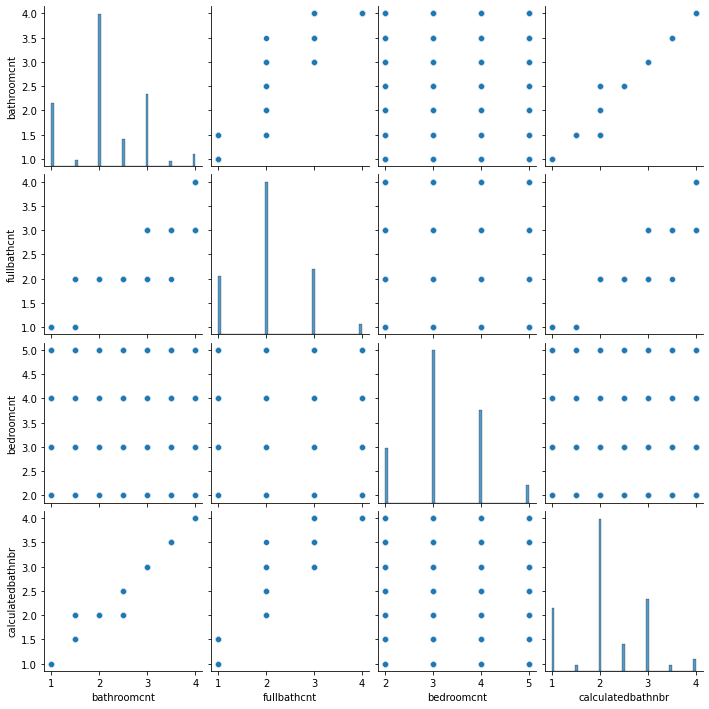

In [37]:
sns.pairplot(data = df2[bath])

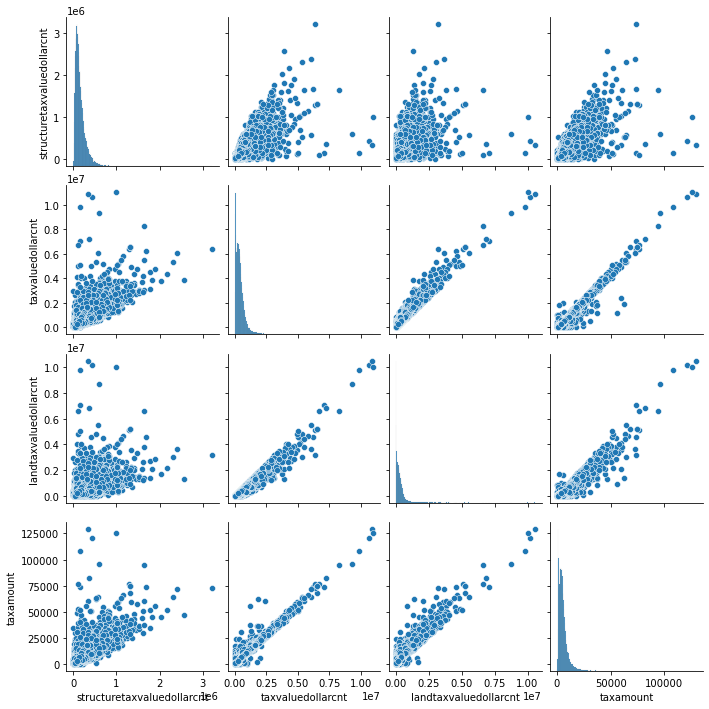

In [17]:
sns.pairplot(data = df2[value])

In [23]:
df2[sqft].corr()

,calculatedfinishedsquarefeet,finishedsquarefeet12
calculatedfinishedsquarefeet,1.000000,0.998013
finishedsquarefeet12,0.998013,1.000000


In [38]:
df2[bath].corr()

,bathroomcnt,fullbathcnt,bedroomcnt,calculatedbathnbr
bathroomcnt,1.000000,0.977535,0.577860,0.999937
fullbathcnt,0.977535,1.000000,0.565157,0.977595
bedroomcnt,0.577860,0.565157,1.000000,0.577833
calculatedbathnbr,0.999937,0.977595,0.577833,1.000000


In [24]:
df2[value].corr()

,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount
structuretaxvaluedollarcnt,1.000000,0.743992,0.539022,0.749919
taxvaluedollarcnt,0.743992,1.000000,0.963723,0.981020
landtaxvaluedollarcnt,0.539022,0.963723,1.000000,0.937631
taxamount,0.749919,0.981020,0.937631,1.000000


In [25]:
df2[loc].corr()

,latitude,longitude,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,censustractandblock
latitude,1.000000,-0.533704,-0.063068,-0.020002,0.578863,0.015413,-0.009538
longitude,-0.533704,1.000000,-0.385093,0.002332,-0.357550,0.029303,-0.039512
rawcensustractandblock,-0.063068,-0.385093,1.000000,-0.042617,-0.601546,0.041552,0.105129
regionidcity,-0.020002,0.002332,-0.042617,1.000000,0.064606,-0.012975,-0.006626
regionidcounty,0.578863,-0.357550,-0.601546,0.064606,1.000000,-0.050838,-0.061629
regionidzip,0.015413,0.029303,0.041552,-0.012975,-0.050838,1.000000,0.004016
censustractandblock,-0.009538,-0.039512,0.105129,-0.006626,-0.061629,0.004016,1.000000


In [116]:
df2.censustractandblock.nunique()

29906

In [42]:
df2 = df2.drop(columns=(['finishedsquarefeet12', 'taxvaluedollarcnt', 'taxamount', 'calculatedbathnbr', 'fullbathcnt']))

In [66]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48437 entries, 0 to 77579
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   propertylandusetypeid         48437 non-null  float64
 1   parcelid                      48437 non-null  int64  
 2   logerror                      48437 non-null  float64
 3   transactiondate               48437 non-null  object 
 4   bathroomcnt                   48437 non-null  float64
 5   bedroomcnt                    48437 non-null  float64
 6   calculatedfinishedsquarefeet  48437 non-null  float64
 7   fips                          48437 non-null  float64
 8   latitude                      48437 non-null  float64
 9   longitude                     48437 non-null  float64
 10  lotsizesquarefeet             48437 non-null  float64
 11  propertycountylandusecode     48437 non-null  object 
 12  rawcensustractandblock        48437 non-null  float64
 13  r

***
#### Key Takeaways: 

    * calculatedfinishedsquarefeet & finishedsquarefeet12 highly correlated 
        * drop finishedsquarefeet12 
    * calculatedbathnbr hihgly correlated with bathroomcnt less so with bedroomcnt
        * going to drop all except bathroomcnt & bedroomcnt 
    * taxvaluedollarcount highly correlated with all others in this group     
        * correlation b/w taxvaluedollarcnt & structuretaxvaluedollarcnt weaker, keep these two and drop others       
    * keeping taxvaluedollarcount & structuretaxvaluedollarcnt, dropping others
    * Not able to deal w/location features using correlation
        * categorical features
***

In [44]:
#dropping the id columns, as parcelid is a unique identifier
df2 = df2.drop(columns=('id'))

In [108]:
df2.corr().sort_values('logerror', ascending=False)

,propertylandusetypeid,parcelid,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,censustractandblock
logerror,0.007813,0.007329,1.000000,0.017394,0.024607,0.018807,0.006185,-0.017668,0.023947,0.007760,0.006177,0.007051,-0.023491,-0.004057,0.015362,0.016264,-0.017032,-0.022973,0.005376
bedroomcnt,-0.037039,0.084343,0.024607,0.577860,1.000000,0.596151,0.144724,0.029701,0.001573,0.004564,0.145421,-0.048262,-0.149293,0.021119,0.199738,0.358112,0.316906,0.069436,0.020018
longitude,-0.070655,-0.064304,0.023947,0.011765,0.001573,0.006872,-0.382218,-0.533704,1.000000,-0.011295,-0.385093,0.002332,-0.357550,0.029303,-0.000911,0.094102,-0.093933,-0.005706,-0.039512
calculatedfinishedsquarefeet,-0.013221,0.073991,0.018807,0.788009,0.596151,1.000000,0.138223,-0.013393,0.006872,0.024071,0.138133,-0.055316,-0.173287,0.027338,0.137242,0.468993,0.656188,0.294643,0.012608
bathroomcnt,-0.006341,0.071713,0.017394,1.000000,0.577860,0.788009,0.128785,0.016788,0.011765,0.014763,0.129009,-0.059692,-0.168397,0.030270,0.115692,0.536101,0.561721,0.241117,0.012930
yearbuilt,0.033239,0.175206,0.016264,0.536101,0.358112,0.468993,0.294109,0.077893,0.094102,0.032060,0.296487,-0.086706,-0.341102,0.056638,0.198839,1.000000,0.383528,0.004507,0.033793
roomcnt,0.018501,0.428303,0.015362,0.115692,0.199738,0.137242,0.742506,-0.310234,-0.000911,-0.014830,0.740281,-0.051082,-0.782967,0.042296,1.000000,0.198839,-0.029382,0.038051,0.077062
propertylandusetypeid,1.000000,0.033827,0.007813,-0.006341,-0.037039,-0.013221,0.077009,0.034126,-0.070655,0.006389,0.077344,0.001216,-0.012133,0.003807,0.018501,0.033239,-0.020942,-0.013590,0.008212
lotsizesquarefeet,0.006389,-0.013941,0.007760,0.014763,0.004564,0.024071,-0.010700,0.058983,-0.011295,1.000000,-0.010033,-0.009217,0.024462,0.005129,-0.014830,0.032060,0.019816,-0.003846,-0.001359
parcelid,0.033827,1.000000,0.007329,0.071713,0.084343,0.073991,0.532157,-0.172625,-0.064304,-0.013941,0.531907,-0.023033,-0.394721,0.028112,0.428303,0.175206,0.047368,0.010212,0.056422


In [67]:
df2.logerror.describe()

count    48437.000000
mean         0.016504
std          0.168290
min         -4.655420
25%         -0.024978
50%          0.006045
75%          0.038109
max          3.394544
Name: logerror, dtype: float64

<AxesSubplot:xlabel='logerror', ylabel='Count'>

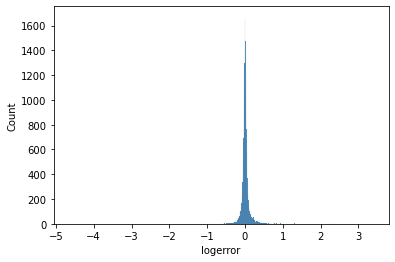

In [68]:
sns.histplot(data=df2.logerror)

In [71]:
# Create log quartile column to separate logerror extremes and identify trends
log_quantile = [1,2,3,4]
df2['log_quantile'] = pd.qcut(df2['logerror'], q=[0,.25,.5,.75,1], labels = log_quantile)

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

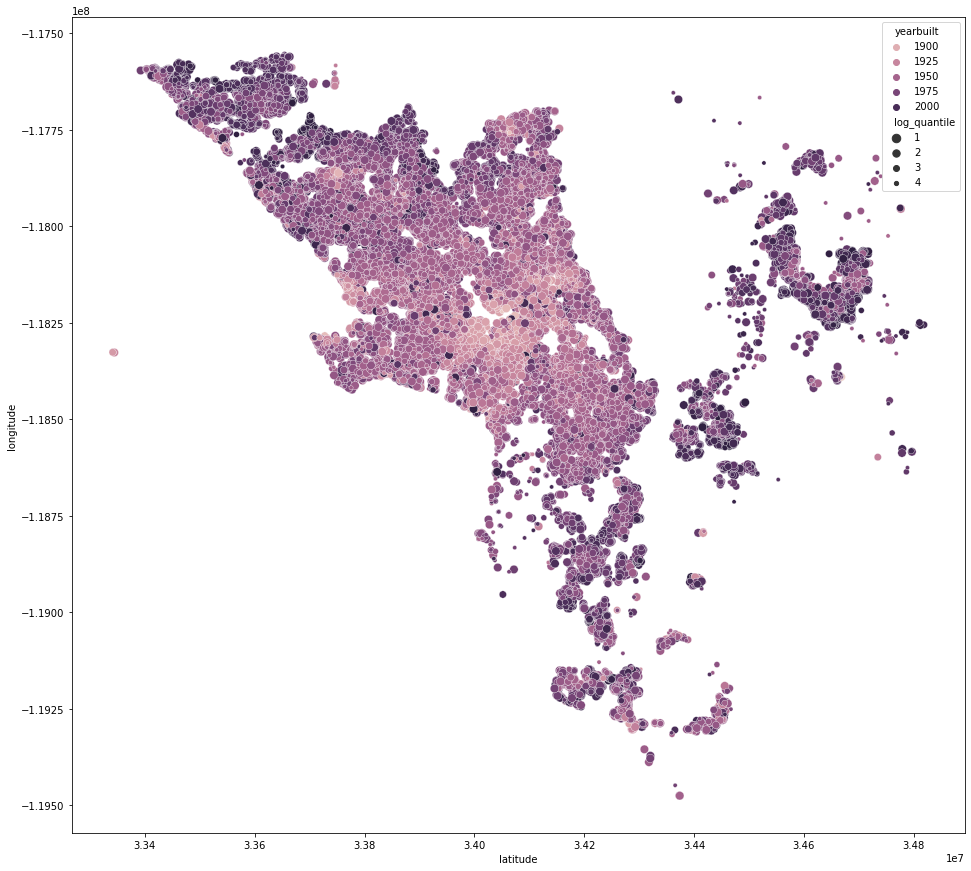

In [145]:
plt.figure(figsize=(16, 15))
sns.scatterplot(data=df2, x=df2.latitude, y=df2.longitude, hue=df2.yearbuilt, size=df2.log_quantile)

<AxesSubplot:xlabel='transactiondate', ylabel='logerror'>

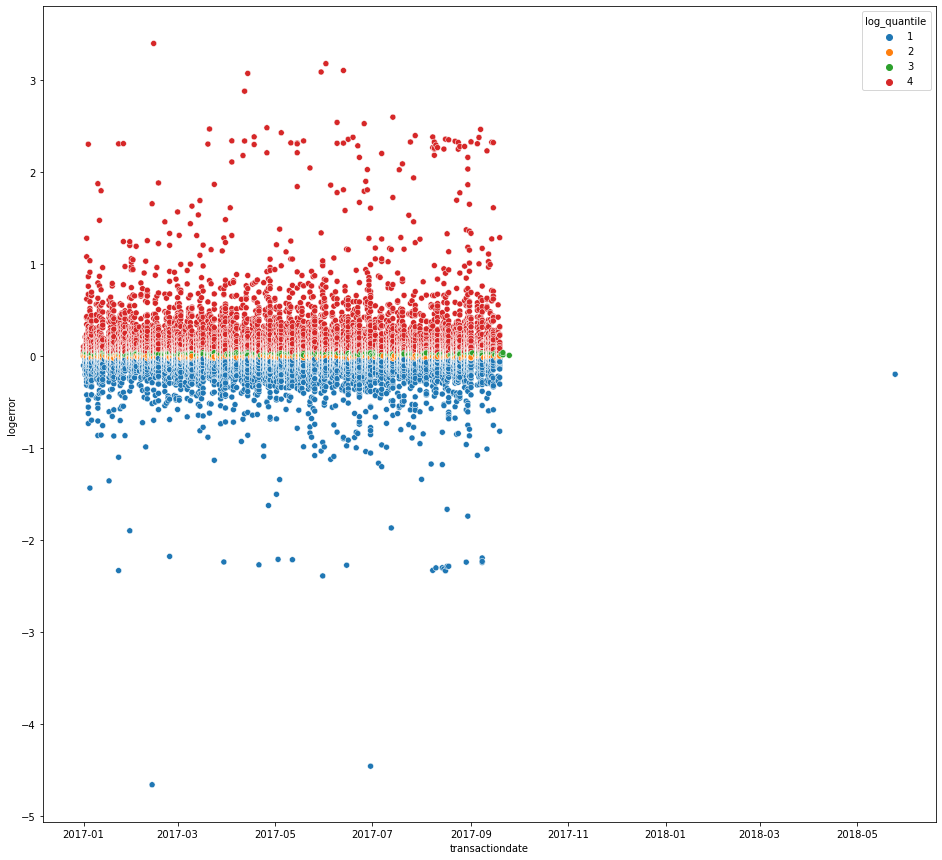

In [106]:
plt.figure(figsize=(16, 15))
sns.scatterplot(data=df2, x=df2.transactiondate, y=df2.logerror, hue=df2.log_quantile)

<AxesSubplot:xlabel='yearbuilt', ylabel='logerror'>

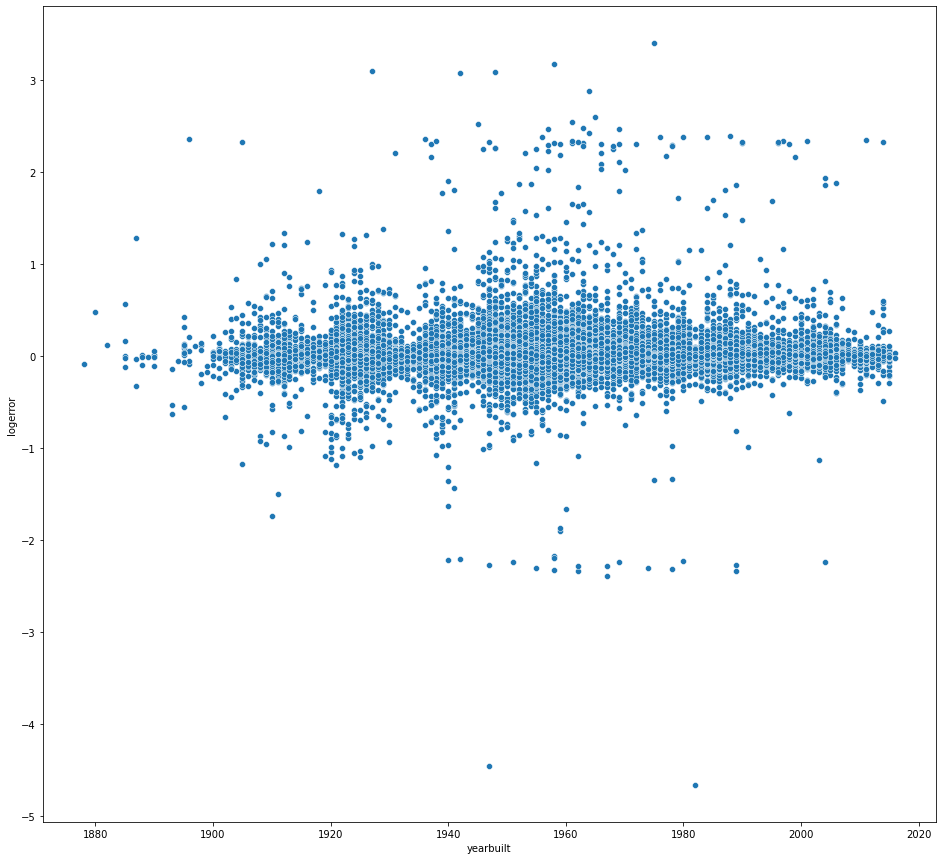

In [136]:
plt.figure(figsize=(16, 15))
sns.scatterplot(data=df2, x=df2.yearbuilt, y=df2.logerror)

In [6]:
# Assign X to X_train for simplicity
X = X_train

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

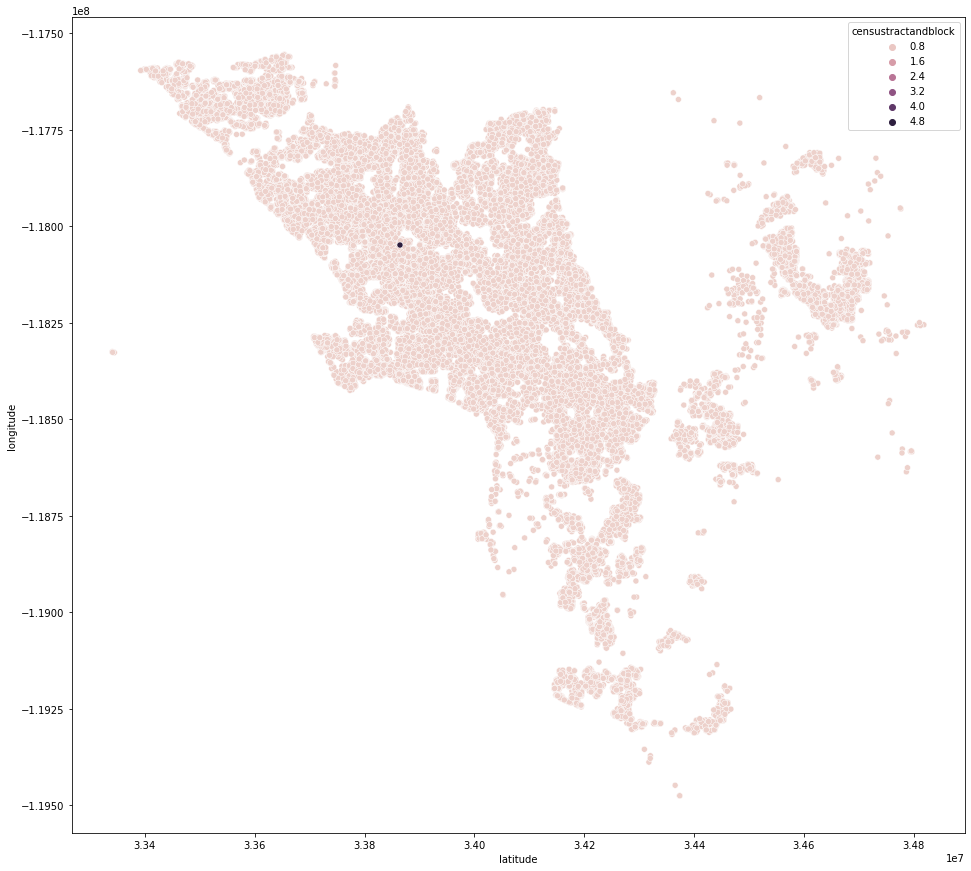

In [133]:
plt.figure(figsize=(16, 15))
sns.scatterplot(data=df2, x=df2.latitude, y=df2.longitude, hue=df2.censustractandblock)

In [8]:
# Distribution of Assessed Values
X.landtaxvaluedollarcnt.describe()

count    2.712400e+04
mean     2.824450e+05
std      3.349906e+05
min      1.000000e+03
25%      6.896600e+04
50%      2.059020e+05
75%      3.816725e+05
max      1.054104e+07
Name: landtaxvaluedollarcnt, dtype: float64

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

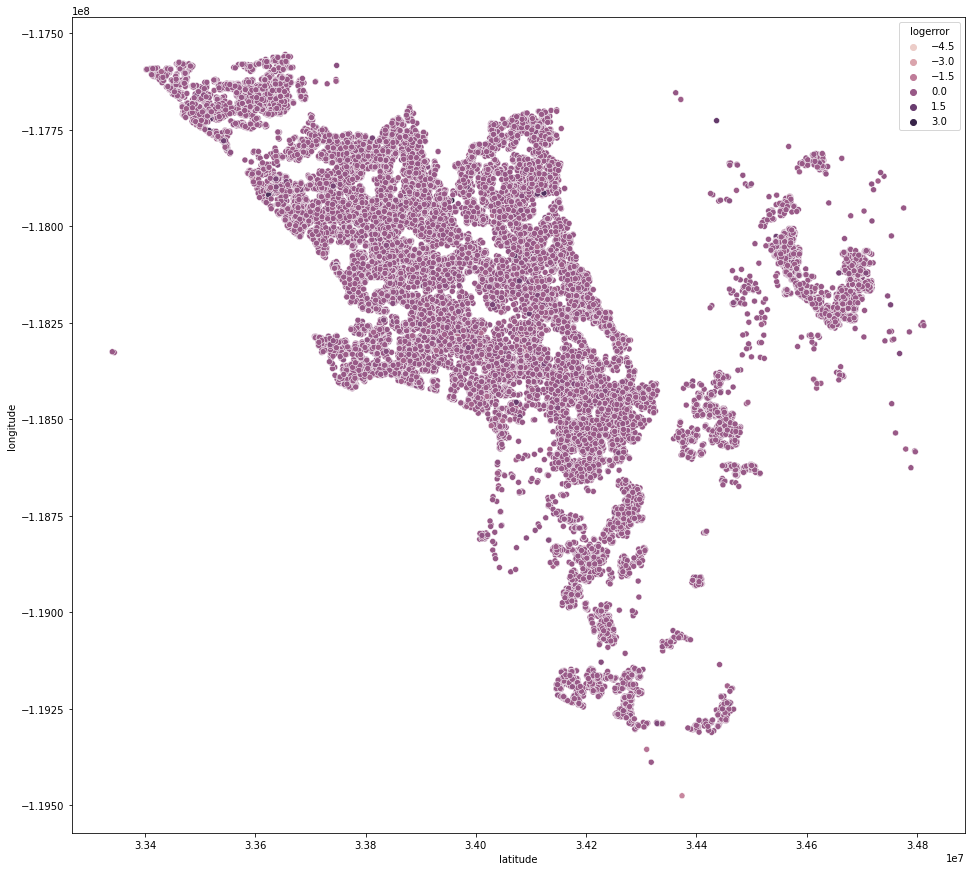

In [9]:
plt.figure(figsize=(16, 15))
sns.scatterplot(data=X, x=X.latitude, y=X.longitude, hue=X.logerror)

In [10]:
X.logerror.describe()

count    27124.000000
mean         0.016126
std          0.170258
min         -4.655420
25%         -0.025285
50%          0.005858
75%          0.037583
max          3.394544
Name: logerror, dtype: float64

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27124 entries, 68779 to 56030
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   propertylandusetypeid         27124 non-null  float64
 1   parcelid                      27124 non-null  int64  
 2   id                            27124 non-null  int64  
 3   logerror                      27124 non-null  float64
 4   transactiondate               27124 non-null  object 
 5   id                            27124 non-null  int64  
 6   bathroomcnt                   27124 non-null  float64
 7   bedroomcnt                    27124 non-null  float64
 8   calculatedbathnbr             27124 non-null  float64
 9   calculatedfinishedsquarefeet  27124 non-null  float64
 10  finishedsquarefeet12          27124 non-null  float64
 11  fips                          27124 non-null  float64
 12  fullbathcnt                   27124 non-null  float64
 1

0     6.059063e+13
1     6.111001e+13
2     6.059022e+13
3     6.037300e+13
6     6.037461e+13
7     6.037302e+13
8     6.037500e+13
10    6.037920e+13
13    6.059089e+13
15    6.111005e+13
16    6.059052e+13
18    6.037532e+13
21    6.059042e+13
22    6.059052e+13
23    6.037232e+13
25    6.037578e+13
27    6.037920e+13
28    6.037189e+13
29    6.059076e+13
30    6.037670e+13
31    6.059076e+13
32    6.037800e+13
33    6.037461e+13
36    6.059053e+13
38    6.037140e+13
41    6.037122e+13
42    6.037125e+13
43    6.037218e+13
44    6.037462e+13
47    6.037601e+13
49    6.037119e+13
52    6.059032e+13
53    6.037127e+13
54    6.037405e+13
57    6.037432e+13
58    6.059032e+13
60    6.059042e+13
61    6.037572e+13
63    6.037408e+13
65    6.037403e+13
66    6.059042e+13
67    6.037107e+13
70    6.037110e+13
71    6.037138e+13
72    6.037105e+13
73    6.037402e+13
75    6.037403e+13
78    6.037570e+13
81    6.037800e+13
83    6.059022e+13
Name: censustractandblock, dtype: float64